In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
loan = pd.read_csv("Train_Data.csv")
loan.set_index("ID", inplace = True)

In [26]:
loan.reset_index(drop=True, inplace = True)

In [27]:
loan.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status
0,5849,0.0,NaN,360.0,1.0,Male,No,0,Graduate,No,Urban,Y
1,4583,1508.0,128.0,360.0,1.0,Male,Yes,1,Graduate,No,Rural,N
2,3000,0.0,66.0,360.0,1.0,Male,Yes,0,Graduate,Yes,Urban,Y
3,2583,2358.0,120.0,360.0,1.0,Male,Yes,0,Not Graduate,No,Urban,Y
4,6000,0.0,141.0,360.0,1.0,Male,No,0,Graduate,No,Urban,Y


In [28]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income_of_Applicant        614 non-null    int64  
 1   Income_of_Joint_Applicant  614 non-null    float64
 2   Loan_Amount_Requirement    592 non-null    float64
 3   Loan_Amount_Term           600 non-null    float64
 4   Credit_History             564 non-null    float64
 5   Gender                     601 non-null    object 
 6   Is_Married                 611 non-null    object 
 7   No_of_Dependents           599 non-null    object 
 8   Level_of_Education         614 non-null    object 
 9   IS_Self_Employed           582 non-null    object 
 10  Area_of_Property           614 non-null    object 
 11  Loan_Status                614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [52]:
loan["No_of_Dependents"].value_counts()

0     345
1     102
2     101
3+     51
Name: No_of_Dependents, dtype: int64

In [60]:
loan["Loan_Amount_Term"].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [45]:
loan.isnull().sum()

Income_of_Applicant           0
Income_of_Joint_Applicant     0
Loan_Amount_Requirement      22
Loan_Amount_Term             14
Credit_History               50
Gender                       13
Is_Married                    3
No_of_Dependents             15
Level_of_Education            0
IS_Self_Employed             32
Area_of_Property              0
Loan_Status                   0
dtype: int64

array([[<AxesSubplot:title={'center':'Income_of_Applicant'}>,
        <AxesSubplot:title={'center':'Income_of_Joint_Applicant'}>],
       [<AxesSubplot:title={'center':'Loan_Amount_Requirement'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

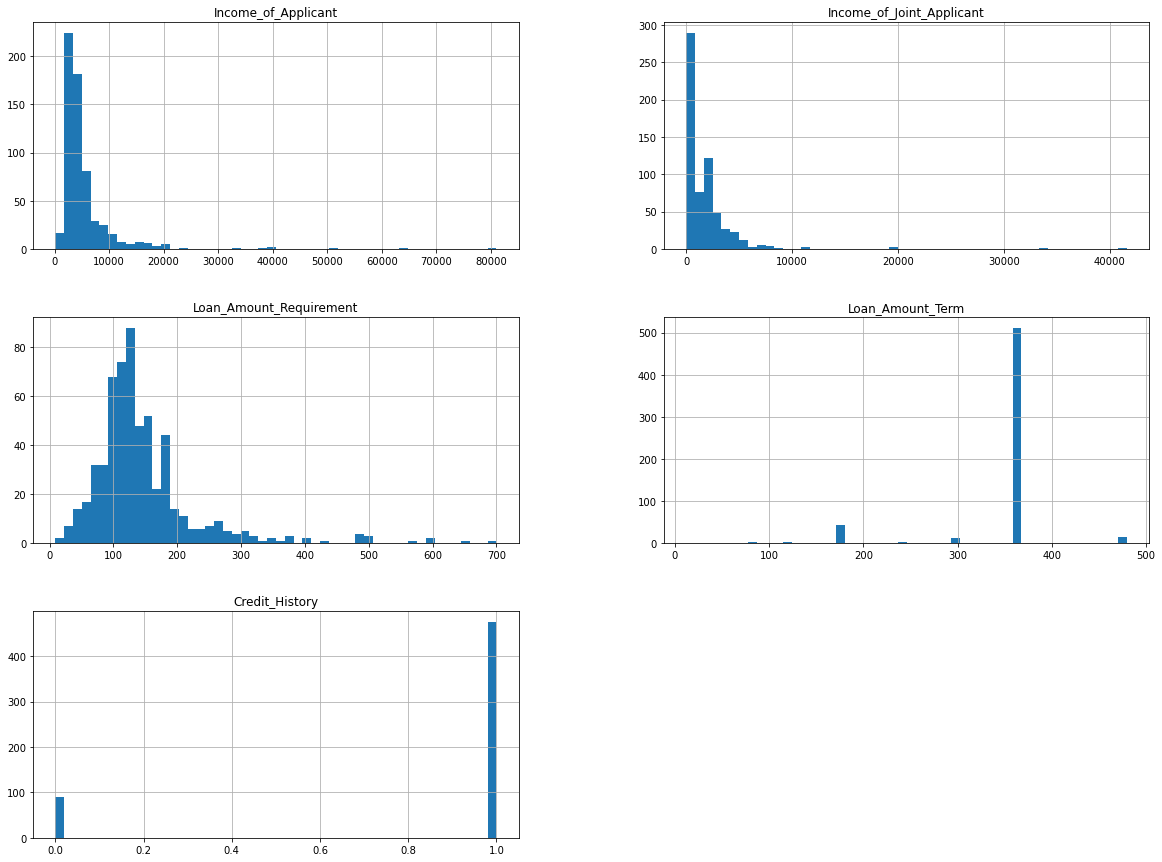

In [49]:
loan.hist(bins = 50, figsize = (20,15))

Create a test set to prevent data snooping bias!

In [62]:
import numpy as np

In [64]:
np.random.seed(42)
shuffles = np.random.permutation(len(loan))

In [89]:
test_ratio = 0.8
train_set_size = int(len(loan) * test_ratio)

train_index = shuffles[:train_set_size]
test_index = shuffles[train_set_size:]

In [98]:
train_set = loan.iloc[train_index]
test_set = loan.iloc[test_index]